# Кластерізація та зменшення розмірності

---
<a name="0"/>

### Зміст:
* [1. Імпорт данних](#1)
* [2. Частина 1. Підбір кількості кластерів використовуючи різну метрику](#2)
* [3. Частина 2. Побудова графіку втрати інформації](#3)
* [4. Частина 3. Пошук кластерів на зменшених данних. Порівняння результатів](#4)
* [5. Висновок](#5)

---

Імпорт бібліотек

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, HDBSCAN
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                             calinski_harabasz_score)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

#from hdbscan import HDBSCAN # https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

import statsmodels.formula.api as smf # https://www.statsmodels.org/stable/index.html

In [6]:
# Налаштуваня візуалізація
sns.set()
%config InlineBackend.figure_format = 'svg'

# Ігнорування помилок при побудові моделі
warnings.filterwarnings("ignore")

random_state=4

---
<a name="1"/>

### 1. Імпорт данних

[зміст](#0)

In [7]:
url = 'https://archive.ics.uci.edu/static/public/573/south+german+credit+update.zip'

In [8]:
resp = urlopen(url)
myzip = ZipFile(BytesIO(resp.read()))
with myzip.open('SouthGermanCredit.asc') as myfile:
    data = pd.read_csv(myfile, delimiter=' ')

data.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


Маштабування фіч

In [9]:
data_scaled = MaxAbsScaler().fit_transform(data)

---
<a name="2"/>

### 2. Частина 1. Підбір кількості кластерів використовуючи різну метрику

[зміст](#0)

Створюємо таблицю сбору результатів кількості кластерів з моделей і іх метрики.

In [10]:
score_table = pd.DataFrame(columns=['Model', 'Clusters', 'Metric', 'Score', 'FullData'])

Створюємо функції навчань декількох моделей кластерізації

#### KMeans

In [11]:
def kMeans_model(a_data, data_size, cluster_couts):
    kmeans = KMeans(n_clusters=cluster_couts, random_state=random_state, n_init='auto').fit(a_data)
    sil_score = silhouette_score(a_data, kmeans.labels_)
    db_score = davies_bouldin_score(a_data, kmeans.labels_)
    ca_score = calinski_harabasz_score(a_data, kmeans.labels_)
    score_table.loc[len(score_table.index)] = ['KMeans', cluster_couts, 'Solhouette', sil_score, data_size]
    score_table.loc[len(score_table.index)] = ['KMeans', cluster_couts, 'Davies-Bouldin', db_score, data_size]
    score_table.loc[len(score_table.index)] = ['KMeans', cluster_couts, 'Calinski&Harabasz', ca_score, data_size]

#### HDBSCAN

In [12]:
def hdbscan_model(a_data, data_size, cluster_size):
    hdbscan = HDBSCAN(min_cluster_size=cluster_size).fit(a_data)
    sil_score = silhouette_score(a_data, hdbscan.labels_)
    db_score = davies_bouldin_score(a_data, hdbscan.labels_)
    ca_score = calinski_harabasz_score(a_data, hdbscan.labels_)
    score_table.loc[len(score_table.index)] = ['HDBSCAN', np.unique(hdbscan.labels_).shape[0], 'Solhouette', sil_score, data_size]
    score_table.loc[len(score_table.index)] = ['HDBSCAN', np.unique(hdbscan.labels_).shape[0], 'Davies-Bouldin', db_score, data_size]
    score_table.loc[len(score_table.index)] = ['HDBSCAN', np.unique(hdbscan.labels_).shape[0], 'Calinski&Harabasz', ca_score, data_size]

#### Agglomerative Clustering

In [13]:
def ag_model(a_data, data_size, cluster_couts):
    ag = AgglomerativeClustering(n_clusters=cluster_couts).fit(a_data)
    sil_score = silhouette_score(a_data, ag.labels_)
    db_score = davies_bouldin_score(a_data, ag.labels_)
    ca_score = calinski_harabasz_score(a_data, ag.labels_)
    score_table.loc[len(score_table.index)] = ['AG', np.unique(ag.labels_).shape[0], 'Solhouette', sil_score, data_size]
    score_table.loc[len(score_table.index)] = ['AG', np.unique(ag.labels_).shape[0], 'Davies-Bouldin', db_score, data_size]
    score_table.loc[len(score_table.index)] = ['AG', np.unique(ag.labels_).shape[0], 'Calinski&Harabasz', ca_score, data_size]

Вчимо моделі, вкидуємо різну кількість кластерів, а у випадку hdbscan мінімальну кількість точок в кластері.

In [14]:
for i in range(2, 16):
    kMeans_model(data_scaled, 1, i)
    hdbscan_model(data_scaled, 1, i)
    ag_model(data_scaled, 1, i)

---

Дивимось на результати різних метрик

#### Solhouette

In [15]:
score_table[(score_table['Metric'] == 'Solhouette') & (score_table['FullData'] == 1)].sort_values(by=['Score'], ascending=False).head(5)

,Model,Clusters,Metric,Score,FullData
0,KMeans,2,Solhouette,0.212870,1
6,AG,2,Solhouette,0.212106,1
12,HDBSCAN,3,Solhouette,0.200119,1
21,HDBSCAN,3,Solhouette,0.196382,1
30,HDBSCAN,3,Solhouette,0.193114,1


#### Davies-Bouldin

In [16]:
score_table[(score_table['Metric'] == 'Davies-Bouldin') & (score_table['FullData'] == 1)].sort_values(by=['Score'], ascending=True).head(5)

,Model,Clusters,Metric,Score,FullData
4,HDBSCAN,193,Davies-Bouldin,1.447129,1
1,KMeans,2,Davies-Bouldin,1.830004,1
7,AG,2,Davies-Bouldin,1.832638,1
46,KMeans,7,Davies-Bouldin,2.354671,1
100,KMeans,13,Davies-Bouldin,2.410131,1


#### Calinski&Harabasz

In [18]:
score_table[(score_table['Metric'] == 'Calinski&Harabasz') & (score_table['FullData'] == 1)].sort_values(by=['Score'], ascending=False).head(5)

,Model,Clusters,Metric,Score,FullData
2,KMeans,2,Calinski&Harabasz,241.725482,1
8,AG,2,Calinski&Harabasz,240.264595,1
11,KMeans,3,Calinski&Harabasz,167.741628,1
17,AG,3,Calinski&Harabasz,162.907498,1
20,KMeans,4,Calinski&Harabasz,136.747882,1


По результатам усіх трьох метрик кращій результат це `2` кластера `KMeans`

---
<a name="3"/>

### 3. Частина 2. Побудова графіку втрати інформації

[зміст](#0)

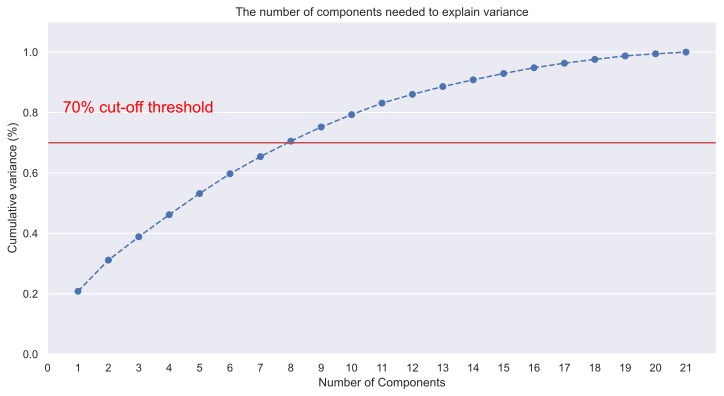

In [20]:
pca = PCA().fit(data_scaled)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 22, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 22, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.7, color='r', linestyle='-')
plt.text(0.5, 0.8, '70% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Як бачимо з гафіка для отримання `70` відсотків інформації необхідно `8` компонентів.

---
<a name="4"/>

### 4. Частина 3. Пошук кластерів на зменшених данних. Порівняння результатів

[зміст](#0)

Витягнемо `8` рандомних компонент з датасету

In [21]:
small_data = data.sample(axis=1, n=8, random_state=random_state)
small_data.head()

,gastarb,telef,verw,laufkont,beszeit,kredit,bishkred,hoehe
0,2,1,2,1,2,1,1,1049
1,2,1,0,1,3,1,2,2799
2,2,1,9,2,4,1,1,841
3,1,1,0,1,3,1,2,2122
4,1,1,0,1,3,1,2,2171


Відскейлемо дані

In [22]:
small_data_scaled = MaxAbsScaler().fit_transform(small_data)

Навчимо нові моделі

In [23]:
for i in range(2, 16):
    kMeans_model(small_data_scaled, 0, i)
    hdbscan_model(small_data_scaled, 0, i)
    ag_model(small_data_scaled, 0, i)

Отримаємо результати метрик

#### Solhouette

In [24]:
score_table[(score_table['Metric'] == 'Solhouette') & (score_table['FullData'] == 0)].sort_values(by=['Score'], ascending=False).head(5)

,Model,Clusters,Metric,Score,FullData
126,KMeans,2,Solhouette,0.408377,0
132,AG,2,Solhouette,0.408377,0
144,KMeans,4,Solhouette,0.304404,0
135,KMeans,3,Solhouette,0.296152,0
150,AG,4,Solhouette,0.285483,0


#### Davies-Bouldin

In [25]:
score_table[(score_table['Metric'] == 'Davies-Bouldin') & (score_table['FullData'] == 0)].sort_values(by=['Score'], ascending=True).head(5)

,Model,Clusters,Metric,Score,FullData
127,KMeans,2,Davies-Bouldin,1.073746,0
133,AG,2,Davies-Bouldin,1.073746,0
130,HDBSCAN,287,Davies-Bouldin,1.182898,0
139,HDBSCAN,127,Davies-Bouldin,1.241824,0
160,AG,5,Davies-Bouldin,1.259030,0


#### Calinski&Harabasz

In [26]:
score_table[(score_table['Metric'] == 'Calinski&Harabasz') & (score_table['FullData'] == 0)].sort_values(by=['Score'], ascending=False).head(5)

,Model,Clusters,Metric,Score,FullData
128,KMeans,2,Calinski&Harabasz,672.443108,0
134,AG,2,Calinski&Harabasz,672.443108,0
137,KMeans,3,Calinski&Harabasz,518.383006,0
143,AG,3,Calinski&Harabasz,471.395007,0
146,KMeans,4,Calinski&Harabasz,427.611790,0


За результатами метрик на даних зі зменшеними кількостями компонент найкращіми є 2 кластери, модель KMeans.

## Отримання предиктів, зменшення кількості фічів та побудова графіків.

Навчимо найрезультатівніші моделі KMeans з 2 кластерами з повними та обрізаними компонентами.

In [27]:
model_100 = KMeans(n_clusters=2, random_state=random_state, n_init='auto').fit_predict(data_scaled)
model_70= KMeans(n_clusters=2, random_state=random_state, n_init='auto').fit_predict(small_data_scaled)

### TSNE

In [28]:
tsne = TSNE(n_components=2, verbose=1, random_state=random_state)

Перетворюємо фічі повної дати

In [29]:
W_100 = tsne.fit_transform(data_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.398044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.638470
[t-SNE] KL divergence after 1000 iterations: 1.237003


In [30]:
tsne_data_100 = pd.DataFrame()
tsne_data_100["comp-1"] = W_100[:,0]
tsne_data_100["comp-2"] = W_100[:,1]
tsne_data_100['y'] = model_100

[Text(0.5, 1.0, 'Full Data Clusterization')]

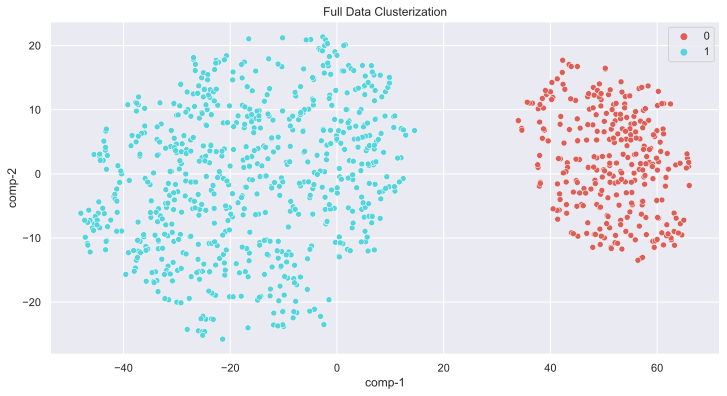

In [32]:
sns.scatterplot(x="comp-1", y="comp-2", hue=tsne_data_100.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=tsne_data_100).set(title="Full Data Clusterization")

Бачимо на графіку чітко разділені `2` кластери.

Перетворюємо фічі з обрізаної дати

In [33]:
W_70 = tsne.fit_transform(small_data_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.192593
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.598259
[t-SNE] KL divergence after 1000 iterations: 0.477717


In [34]:
tsne_data_70 = pd.DataFrame()
tsne_data_70["comp-1"] = W_70[:,0]
tsne_data_70["comp-2"] = W_70[:,1]
tsne_data_70['y'] = model_70

[Text(0.5, 1.0, '70% Data Clusterization')]

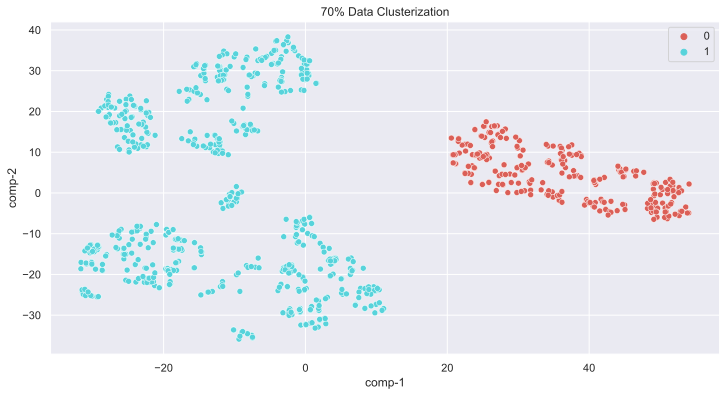

In [38]:
sns.scatterplot(x="comp-1", y="comp-2", hue=tsne_data_70.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=tsne_data_70).set(title="70% Data Clusterization")

На графіку також видний розділ на `2` кластери. Однак на відміну від повної дати тут видно що дані обірвані. Обидва кластери більш стисуті, можливо навіть їх можна розбити на півкластери, особливо `1` кластер

---
<a name="5"/>

### 5. Висновок

[зміст](#0)


Співпадіння кластерів

In [36]:
print((model_70 == model_100).all())

True


Навіть при зменшенні кількості компонент з `21` до `8` кластеризація співпадає. Можемо припустити що ці `2` кластери це результат `0` та `1` по кредиту, змінної `kredit`

In [37]:
np.unique(small_data['kredit'] == model_100)

array([ True])

Повне співпадіня

### Дякую за увагу =)